**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/PIK.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close  Volume  Earnings Yield (EY)  \
0 1999-01-01   570   575  570    570       0                  6.8   
1 1999-01-04   570   570  570    570    1500                  6.8   
2 1999-01-05   570   575  570    575   89639                  6.7   
3 1999-01-06   595   600  595    600  107220                  6.4   
4 1999-01-07   620   640  620    620  206270                  6.2   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  4.1        14.705882      -           -   
1                  4.1        14.705882      -           -   
2                  4.0        14.925373      -           -   
3                  3.8        15.625000      -           -   
4                  3.7        16.129032      -           -   

   Total Return Index (TRI)  
0                     157.0  
1                     157.0  
2                     159.0  
3                     166.0  
4                     171.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11  0.004662  0.000000 -0.004662 -0.018519  0.004684 -0.027652   
2000-05-12 -0.014185 -0.032335 -0.004684 -0.009346 -0.023203  0.000000   
2000-05-15 -0.014185  0.000000  0.000000 -0.004684 -0.009346 -0.023203   
2000-05-16 -0.023530 -0.013857  0.009346  0.009346  0.004662  0.000000   
2000-05-17 -0.047856 -0.004662 -0.004662  0.004684  0.004684  0.000000   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11  0.004636  0.002019 -0.000903   0.008121  ...      0.004662   
2000-05-12 -0.007361 -0.009433 -0.004605   0.000765  ...      0.000000   
2000-05-15 -0.006424 -0.006288 -0.005073   0.000626  ...     -0.004684   
2000-05-16 -0.007369 -0.008811 -0.005554  -0.002007  ...      0.000000   
2000-05-17 -0.010171 -0.007428 -0.004159  -0.002490  ...     -0.013857   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.018868      0.004640           0.009302          0.009302   
2000-05-12    -0.004706     -0.027652           0.000000          0.004684   
2000-05-15    -0.014185     -0.004684          -0.004684          0.000000   
2000-05-16     0.000000     -0.013857           0.009346          0.009346   
2000-05-17    -0.004662     -0.013857          -0.013857          0.000000   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.009302            0.000000           0.000000   
2000-05-12           -0.027652           -0.004684           0.000000   
2000-05-15            0.000000           -0.004684           0.000000   
2000-05-16           -0.013857            0.009346           0.009346   
2000-05-17            0.000000           -0.018519          -0.004662   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.004662          0.004662  
2000-05-12           -0.032335          0.004684  
2000-05-15           -0.004684          0.000000  
2000-05-16           -0.013857          0.000000  
2000-05-17           -0.018519          0.000000  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.01
  dropout = 0.14773496536358716
  units = 102
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 28
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0015808270975257261
RMSE = 0.03975961641572673
MAE = 0.028804873655604062
R-Squared = 0.03666150227253229

Results on Validation set: 
MSE = 0.0008845495291159309
RMSE = 0.029741377391034378
MAE = 0.023168371833391696
R-Squared = 0.017906652075947216

Results on Testing set: 
MSE = 0.0005810761168880569
RMSE = 0.024105520464990107
MAE = 0.01769659651784028
R-Squared = 0.0694639124893095



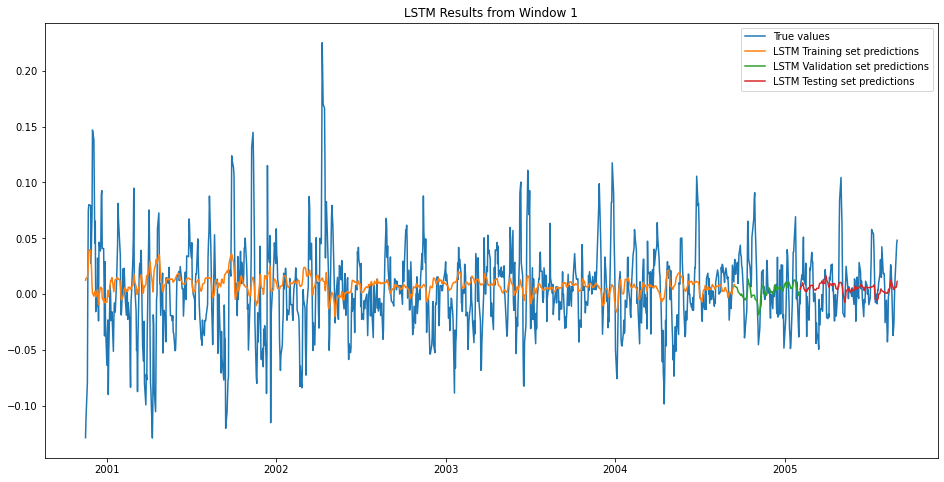

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0013252222472132206
RMSE = 0.03640360211865332
MAE = 0.026689145133055207
R-Squared = 0.03700999792516202

Results on Validation set: 
MSE = 0.0005942226205776821
RMSE = 0.02437668190254125
MAE = 0.016913002493336462
R-Squared = 0.08031707833961521

Results on Testing set: 
MSE = 0.0010241055835518132
RMSE = 0.032001649700473464
MAE = 0.02622657537562409
R-Squared = 0.016076568418085913



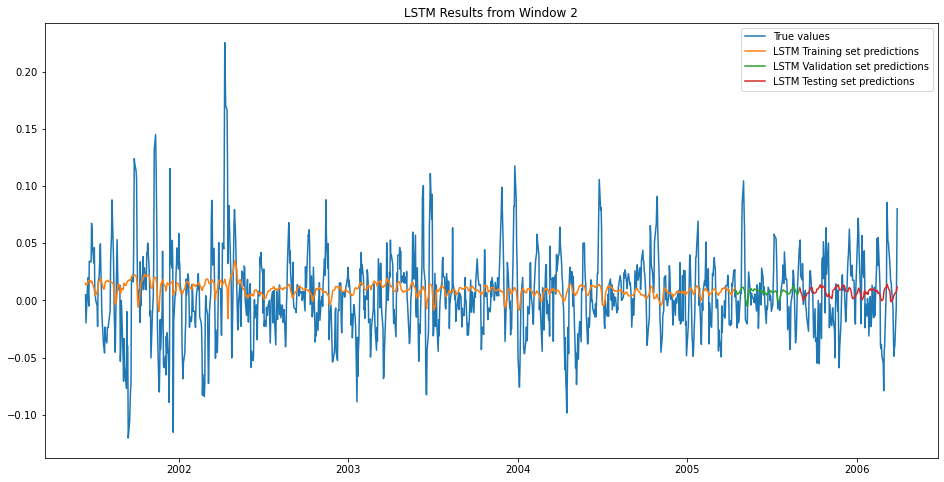

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0008853410956909624
RMSE = 0.029754681912111957
MAE = 0.020789648607655573
R-Squared = 0.20408508118943058

Results on Validation set: 
MSE = 0.0010794031184946276
RMSE = 0.03285427093232519
MAE = 0.027062643310852157
R-Squared = 0.0660755277870424

Results on Testing set: 
MSE = 0.0016903330064890658
RMSE = 0.04111365960953933
MAE = 0.032044418920353056
R-Squared = -0.025076901581426725



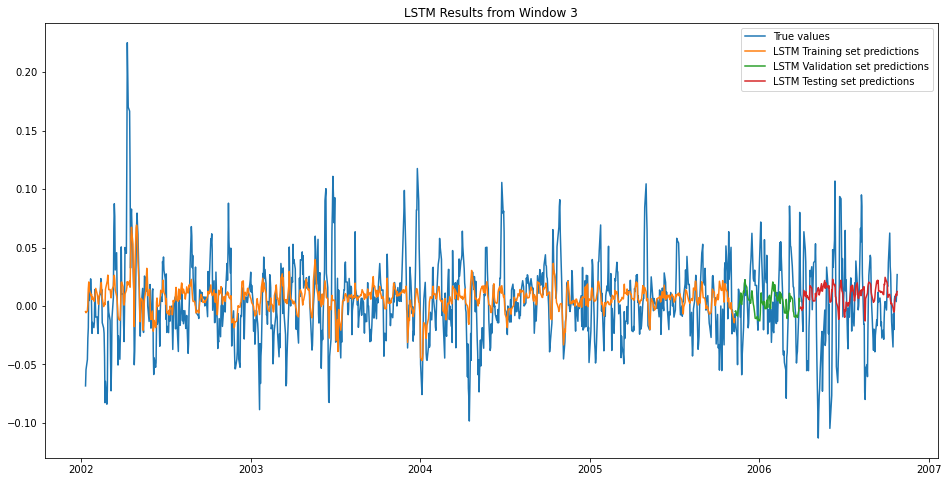

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0009289996549969488
RMSE = 0.030479495648664347
MAE = 0.02288557277317272
R-Squared = 0.07884138132456353

Results on Validation set: 
MSE = 0.0011251704109198938
RMSE = 0.03354355990231051
MAE = 0.025205045967944515
R-Squared = 0.16177882053220016

Results on Testing set: 
MSE = 0.0008439468982910846
RMSE = 0.029050764160191804
MAE = 0.022487836780288126
R-Squared = 0.07173840383493513



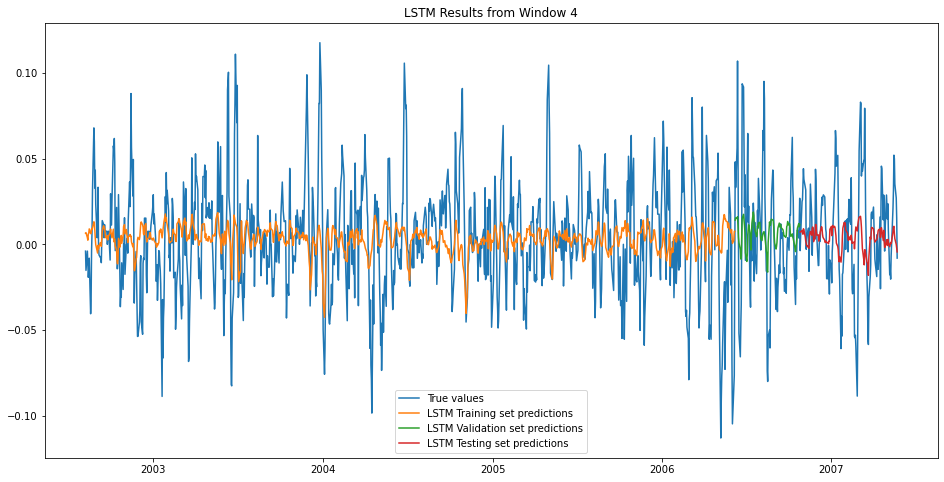

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.000907656764662896
RMSE = 0.030127342475945267
MAE = 0.022834970471644137
R-Squared = 0.12802035111814014

Results on Validation set: 
MSE = 0.0010542418556274138
RMSE = 0.03246909077303234
MAE = 0.024610297851028147
R-Squared = 0.11015273130364611

Results on Testing set: 
MSE = 0.0011391101051011767
RMSE = 0.033750705253389544
MAE = 0.02693007197288317
R-Squared = -0.41847877989145155



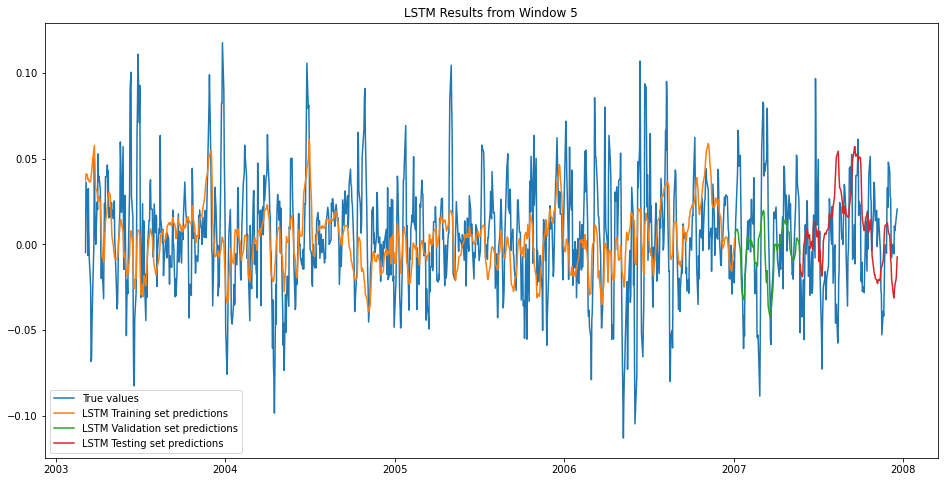

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0009765193804848596
RMSE = 0.031249310080141923
MAE = 0.02361160770720547
R-Squared = 0.06948445387498148

Results on Validation set: 
MSE = 0.0007097368651146245
RMSE = 0.026640887093237427
MAE = 0.021610706072657707
R-Squared = -0.04666596111559285

Results on Testing set: 
MSE = 0.002022923264632169
RMSE = 0.044976919243453845
MAE = 0.034473916537255275
R-Squared = -0.09708029326090761



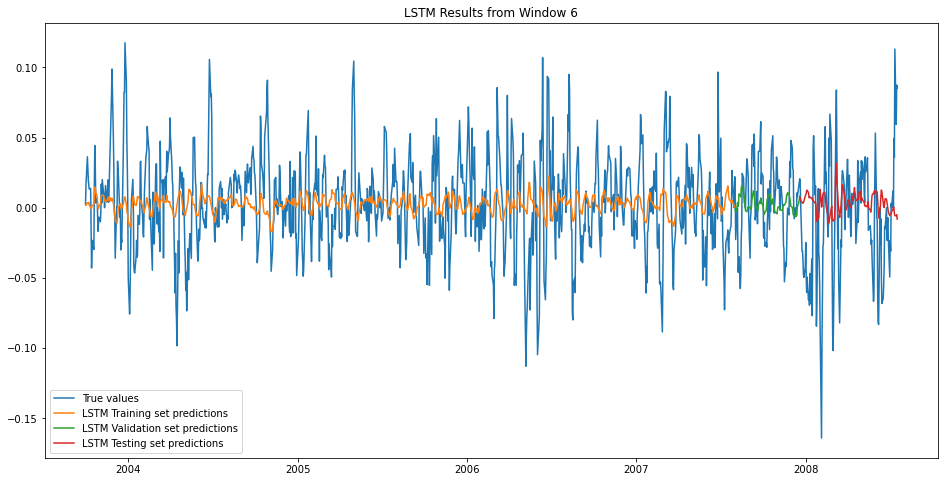

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0010380807567618297
RMSE = 0.03221926064890114
MAE = 0.02424609911799416
R-Squared = 0.039637200172496945

Results on Validation set: 
MSE = 0.0015273630280058115
RMSE = 0.03908149214149598
MAE = 0.029561982850786733
R-Squared = 0.00367538493714914

Results on Testing set: 
MSE = 0.002305550339170266
RMSE = 0.04801614665058272
MAE = 0.03719295957429587
R-Squared = 0.041500220303980595



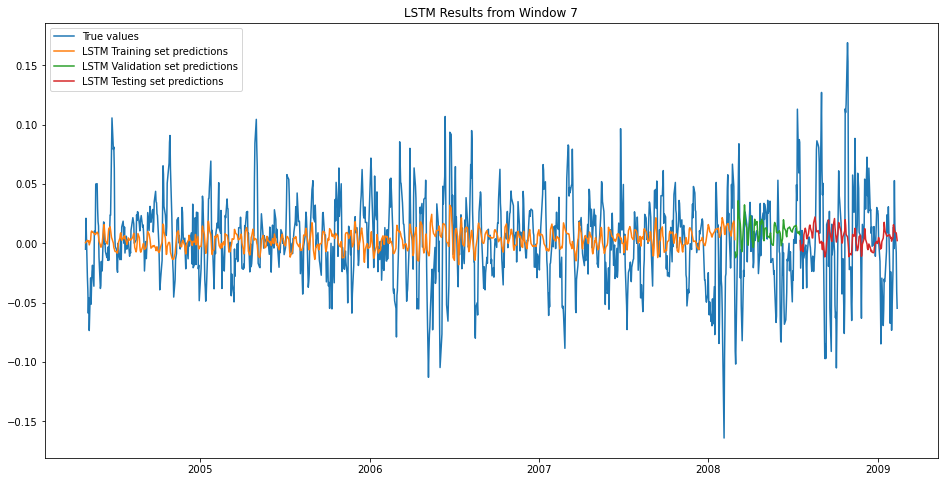

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0012205784510899934
RMSE = 0.034936777915113945
MAE = 0.02675632541763446
R-Squared = -0.00682953964647659

Results on Validation set: 
MSE = 0.0023069303721141273
RMSE = 0.04803051500987812
MAE = 0.0369246394436082
R-Squared = 0.05787819239919678

Results on Testing set: 
MSE = 0.0013990262713407247
RMSE = 0.037403559607886584
MAE = 0.028895857638112213
R-Squared = -0.06251388233878807



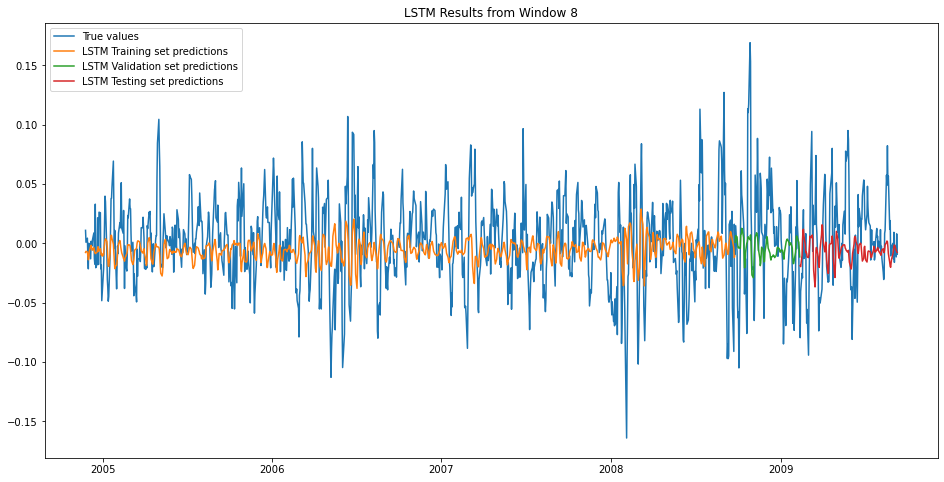

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.001270928944766665
RMSE = 0.035650090389319704
MAE = 0.026960111437028863
R-Squared = 0.12689123224021848

Results on Validation set: 
MSE = 0.0008079240892247889
RMSE = 0.028424005509864174
MAE = 0.021246098896564213
R-Squared = 0.16960559706834477

Results on Testing set: 
MSE = 0.0005746768119711157
RMSE = 0.02397241773311811
MAE = 0.019475148643624207
R-Squared = -0.09565621482484188



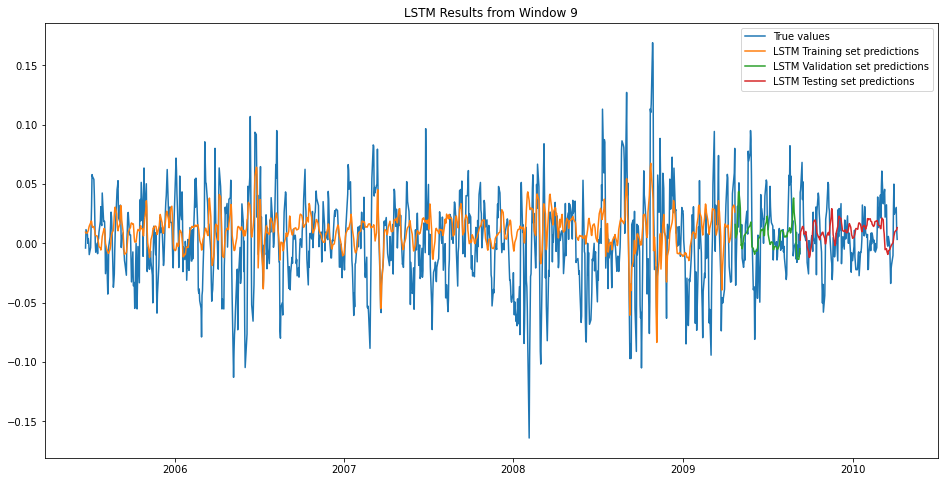

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0012614397059300235
RMSE = 0.03551675246880018
MAE = 0.026742336612430563
R-Squared = 0.147441523593407

Results on Validation set: 
MSE = 0.0004097542845748091
RMSE = 0.02024238831202507
MAE = 0.015951303980315384
R-Squared = -0.055896634695277836

Results on Testing set: 
MSE = 0.0008088558383378325
RMSE = 0.02844039096668385
MAE = 0.023408105132970505
R-Squared = 0.0849210108124262



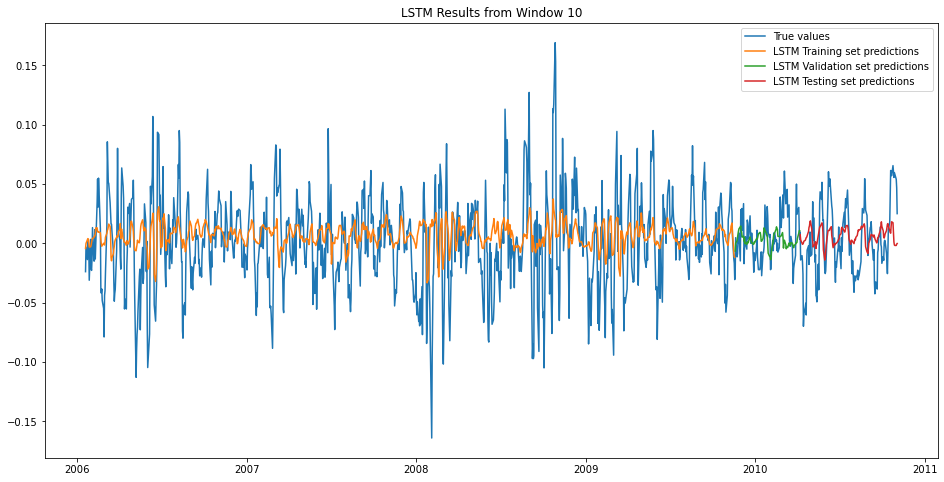

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0007832266571156062
RMSE = 0.027986186898461288
MAE = 0.020961342112364917
R-Squared = 0.39792602778485986

Results on Validation set: 
MSE = 0.0005133429089282704
RMSE = 0.022657071940748882
MAE = 0.018436428428999882
R-Squared = 0.3132624138052422

Results on Testing set: 
MSE = 0.0013474681690961673
RMSE = 0.0367078761180236
MAE = 0.02839607954510361
R-Squared = -0.8550855721868338



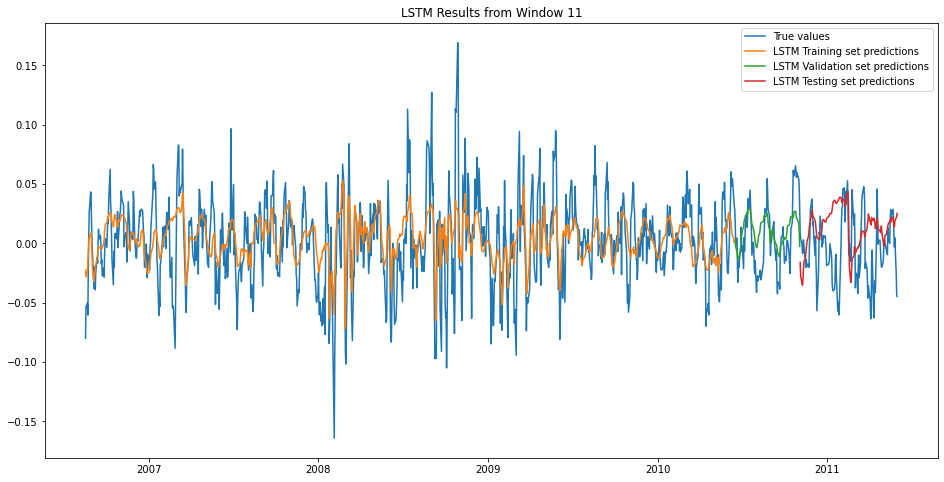

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0011952453738575208
RMSE = 0.03457232092089741
MAE = 0.026070874767121877
R-Squared = 0.039419276183172314

Results on Validation set: 
MSE = 0.0010008906075726703
RMSE = 0.0316368552099078
MAE = 0.026295719641268412
R-Squared = -0.06304003362052368

Results on Testing set: 
MSE = 0.00101698257419923
RMSE = 0.031890164223459715
MAE = 0.025596245639652113
R-Squared = -0.26476282715142707



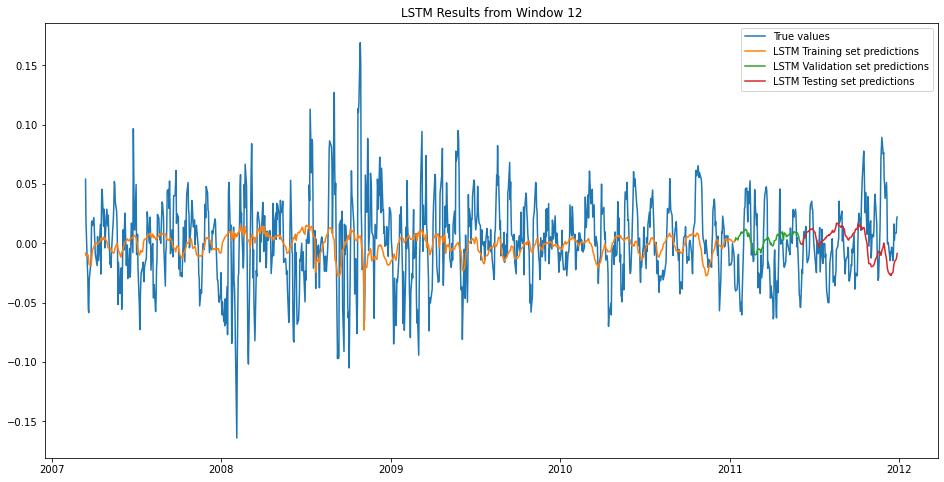

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0008964997663730969
RMSE = 0.029941605941784365
MAE = 0.022015239945832852
R-Squared = 0.2797658614784825

Results on Validation set: 
MSE = 0.0007571970717904119
RMSE = 0.02751721409936718
MAE = 0.0209745006803573
R-Squared = 0.12405304214693691

Results on Testing set: 
MSE = 0.00048286505233584314
RMSE = 0.02197419059569301
MAE = 0.01761434096536989
R-Squared = -0.1890499511937882



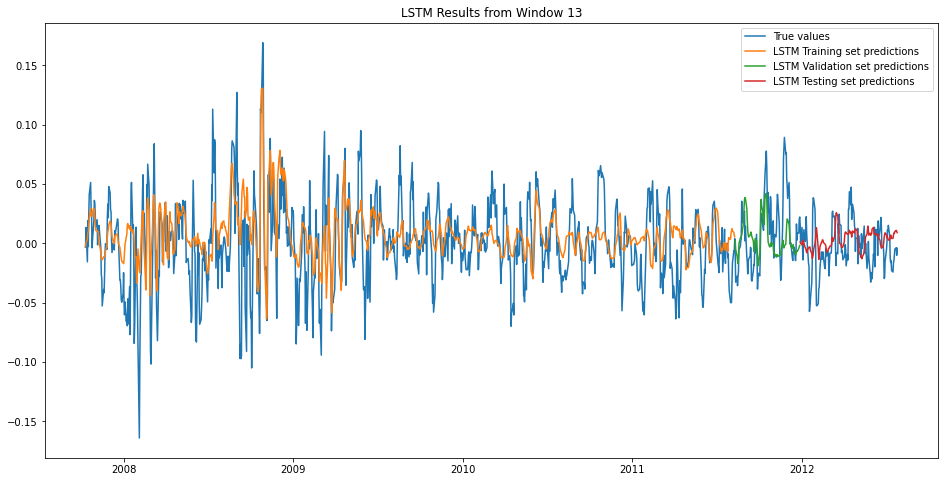

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0011613397598933281
RMSE = 0.03407843540852966
MAE = 0.025308085931556985
R-Squared = -0.016039269192003047

Results on Validation set: 
MSE = 0.0003331733356822616
RMSE = 0.018253036341449102
MAE = 0.01451227185213847
R-Squared = -0.11658884524007385

Results on Testing set: 
MSE = 0.0008691408119392112
RMSE = 0.029481194208159398
MAE = 0.022516308997162386
R-Squared = -0.06915240844296622



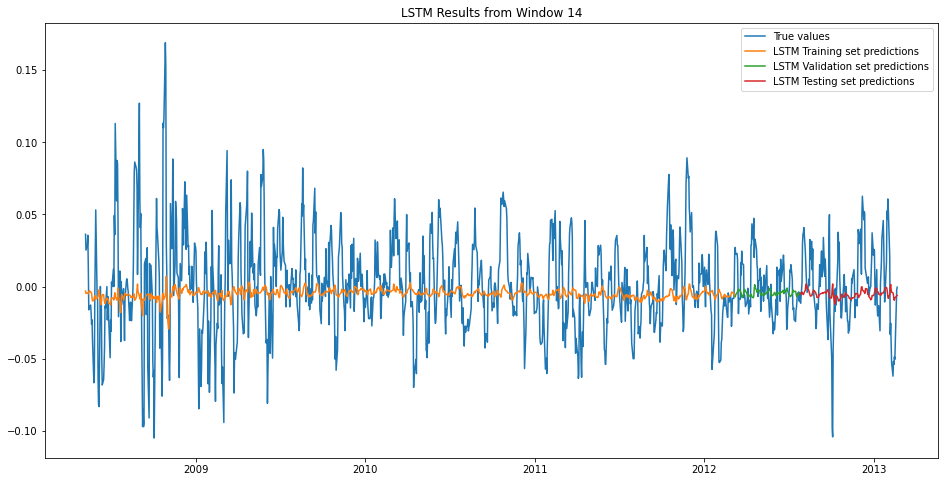

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0005941143103577035
RMSE = 0.024374460206488747
MAE = 0.0184748784175612
R-Squared = 0.27722030872437164

Results on Validation set: 
MSE = 0.0009376312174529784
RMSE = 0.03062076448185085
MAE = 0.02260499715864428
R-Squared = -0.07586795974201888

Results on Testing set: 
MSE = 0.0013264407935596456
RMSE = 0.03642033489082226
MAE = 0.029222752512347513
R-Squared = -0.1955088627083752



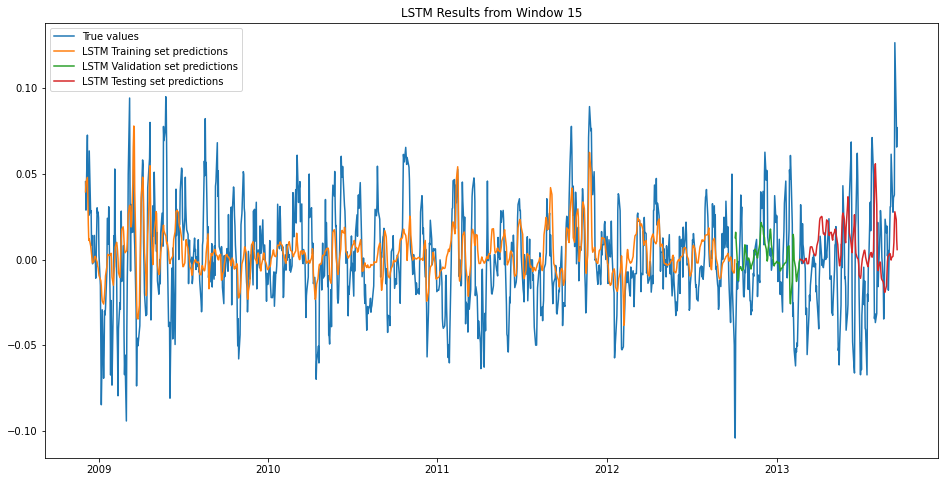

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0006932221095191027
RMSE = 0.026329111445681237
MAE = 0.02022130334019492
R-Squared = -0.011272808083986341

Results on Validation set: 
MSE = 0.0015207139749158684
RMSE = 0.03899633283933078
MAE = 0.0315150571029665
R-Squared = -0.035517244660605796

Results on Testing set: 
MSE = 0.0020763040118296472
RMSE = 0.045566479037003144
MAE = 0.03262418719676161
R-Squared = -0.10500360032017975



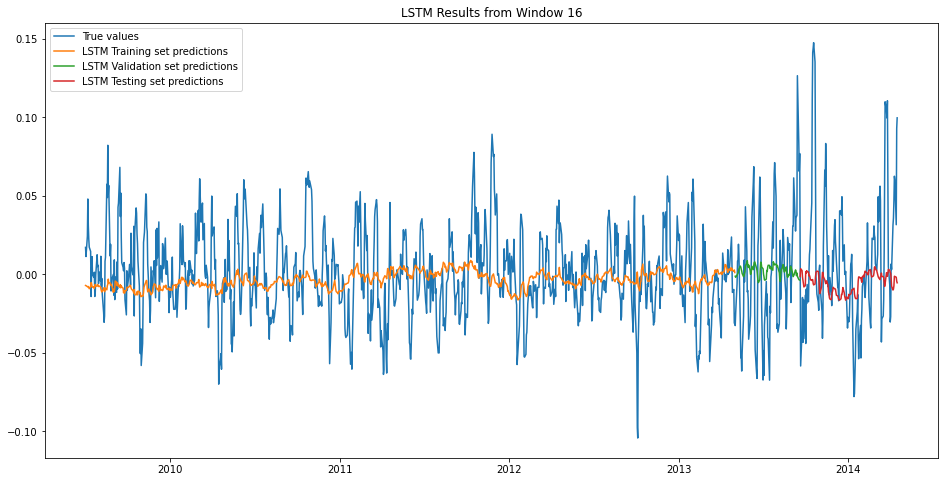

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0009046280881698785
RMSE = 0.030077035894015197
MAE = 0.02277461921999076
R-Squared = -0.019568601080148795

Results on Validation set: 
MSE = 0.0013580386526894687
RMSE = 0.036851575986509295
MAE = 0.02830283798013974
R-Squared = 0.09835456209719373

Results on Testing set: 
MSE = 0.0010243344900653904
RMSE = 0.03200522598053934
MAE = 0.024000833444062245
R-Squared = -0.025608229874485966



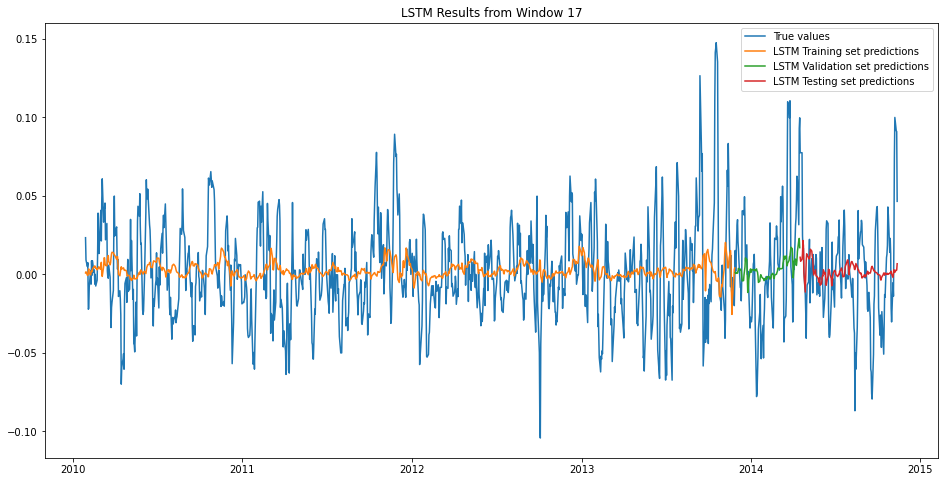

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0008111503265836583
RMSE = 0.028480700949654634
MAE = 0.020831337205656733
R-Squared = 0.15630809172881754

Results on Validation set: 
MSE = 0.0011053686761343998
RMSE = 0.03324708522764665
MAE = 0.025285989969207372
R-Squared = 0.04076497811433777

Results on Testing set: 
MSE = 0.0015423683385406102
RMSE = 0.03927299757518657
MAE = 0.031039796179547482
R-Squared = -0.19266570812137207



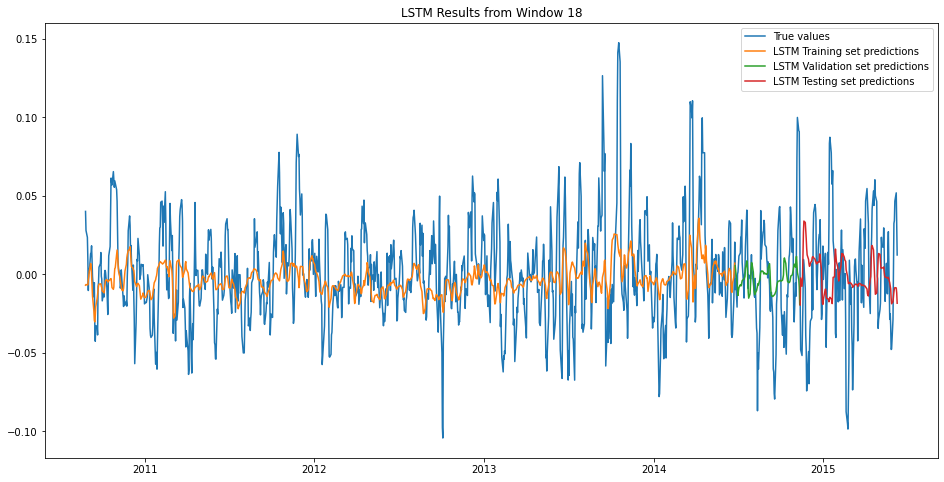

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.001001727951514765
RMSE = 0.031650086121759055
MAE = 0.023967098885280574
R-Squared = 0.03266430605934445

Results on Validation set: 
MSE = 0.0012558505964085503
RMSE = 0.035437982397542755
MAE = 0.027188093462219887
R-Squared = -0.08637452152067593

Results on Testing set: 
MSE = 0.001480878427566857
RMSE = 0.03848218324844443
MAE = 0.03066204567244457
R-Squared = -0.0742415897148414



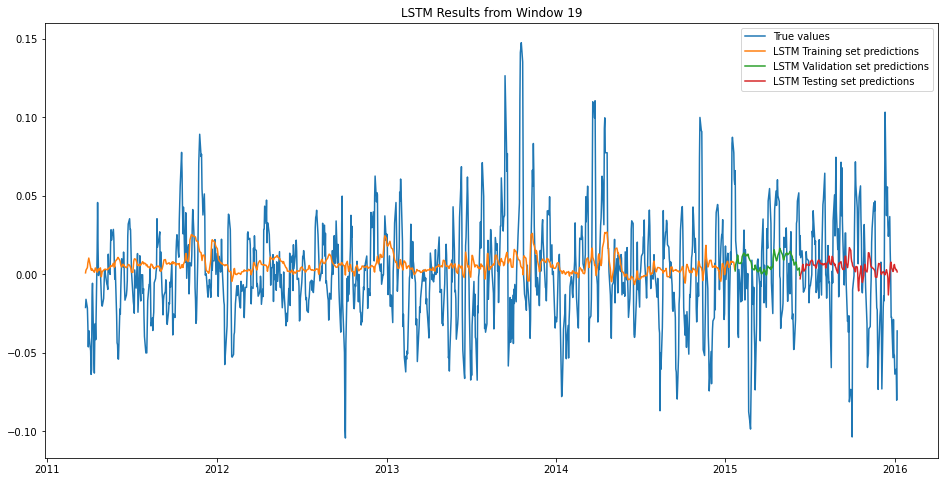

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0008272563813268221
RMSE = 0.028762064969796972
MAE = 0.020925889449049002
R-Squared = 0.22405305784455887

Results on Validation set: 
MSE = 0.0017168978473679959
RMSE = 0.04143546605708684
MAE = 0.03486359453514072
R-Squared = 0.06251981318497579

Results on Testing set: 
MSE = 0.0017795048661339704
RMSE = 0.042184177912269076
MAE = 0.033300106089094304
R-Squared = -0.061775484960922



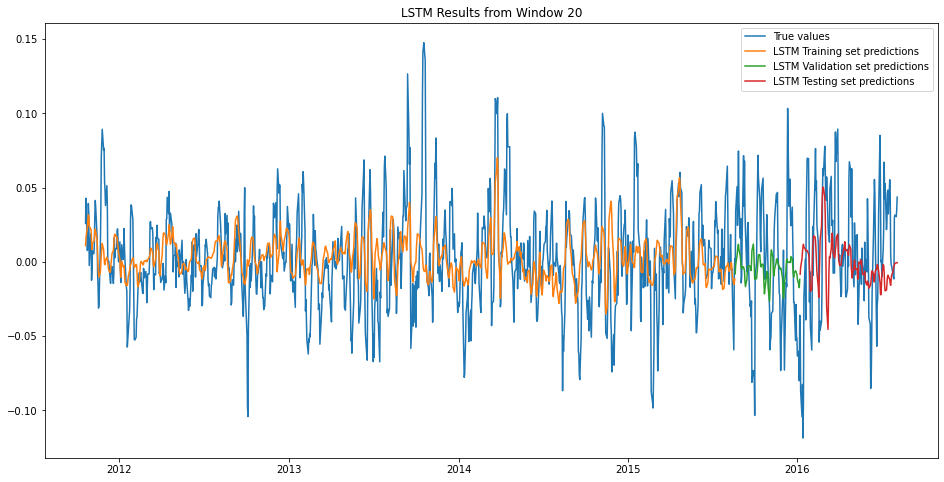

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.001322987628084815
RMSE = 0.03637289688882114
MAE = 0.027916495839175718
R-Squared = -0.03639454631477257

Results on Validation set: 
MSE = 0.0011623478774483052
RMSE = 0.03409322333614563
MAE = 0.02695668458886149
R-Squared = 0.025147354986189363

Results on Testing set: 
MSE = 0.001109614309223692
RMSE = 0.03331087373852106
MAE = 0.02597929359303438
R-Squared = -0.33507251652460424



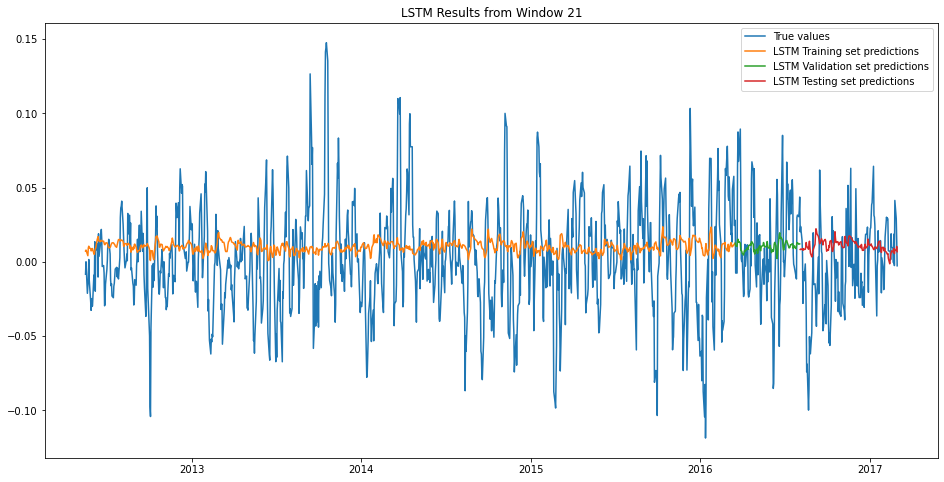

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.001360675136476225
RMSE = 0.036887330297491375
MAE = 0.028280961283216912
R-Squared = 0.0225411242480672

Results on Validation set: 
MSE = 0.0005297855089121527
RMSE = 0.02301706994628449
MAE = 0.01849893783852279
R-Squared = -0.045967188104393264

Results on Testing set: 
MSE = 0.0008431679865530274
RMSE = 0.029037355019922655
MAE = 0.022848804340820476
R-Squared = -0.02729665557488059



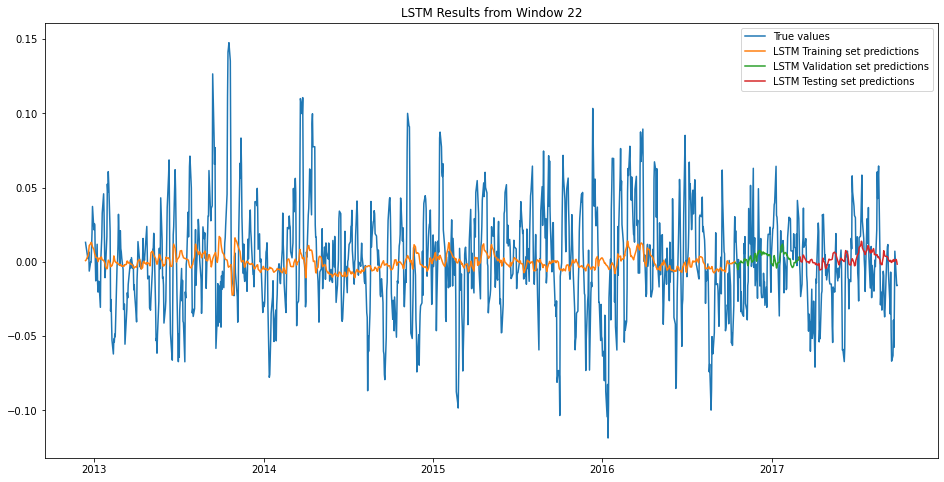

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0013437812885950275
RMSE = 0.03665762251694765
MAE = 0.02812054612896536
R-Squared = 0.010396219104349402

Results on Validation set: 
MSE = 0.0008149045930831128
RMSE = 0.028546533819066595
MAE = 0.021858759089531436
R-Squared = 0.03187871934445896

Results on Testing set: 
MSE = 0.0019990657465654344
RMSE = 0.04471091305895502
MAE = 0.03324883323734511
R-Squared = -0.09396615702636657



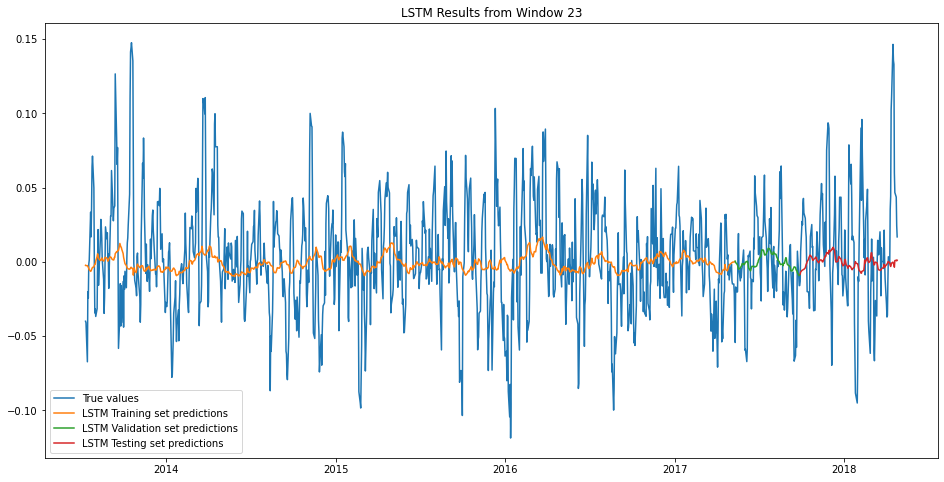

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.000926342899691031
RMSE = 0.030435881779423298
MAE = 0.023085081719887802
R-Squared = 0.2554806691454138

Results on Validation set: 
MSE = 0.001993050753143088
RMSE = 0.0446435970005004
MAE = 0.032099516572185995
R-Squared = 0.07189290255392133

Results on Testing set: 
MSE = 0.0008246285333334792
RMSE = 0.028716346099973776
MAE = 0.02414780047099814
R-Squared = 0.09690730263857217



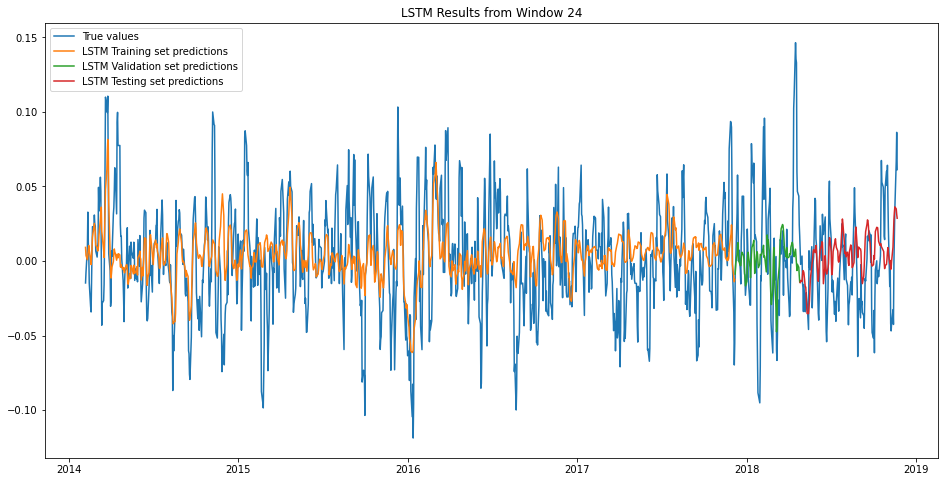

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4983

Results on Training set: 
MSE = 0.0009247614910400733
RMSE = 0.03040989133555188
MAE = 0.022469942018280523
R-Squared = 0.3064804558631443

Results on Validation set: 
MSE = 0.0008844682296733049
RMSE = 0.029740010586301158
MAE = 0.023059442190905815
R-Squared = 0.15225127245427073

Results on Testing set: 
MSE = 0.001634183111460418
RMSE = 0.04042503075398234
MAE = 0.032369084536153364
R-Squared = -0.1391658837807308



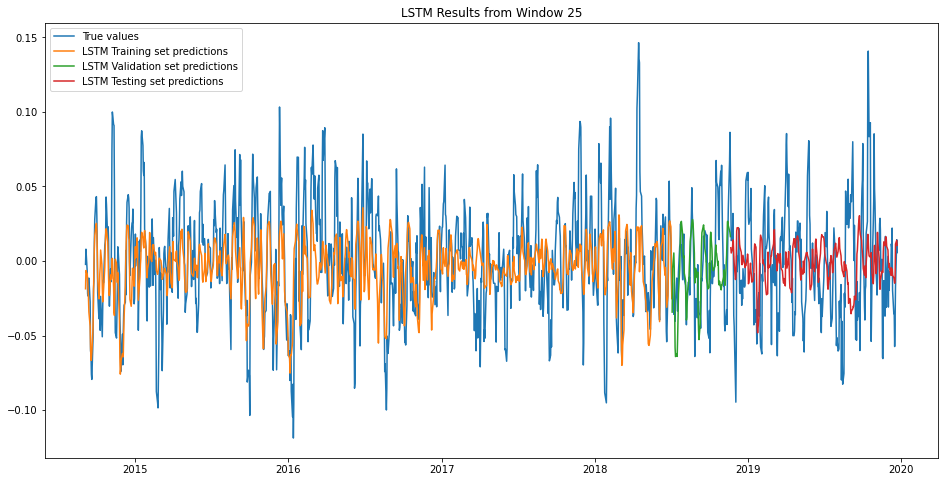

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 135
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.01
  dropout =  0.03283574290902178
  units = 134

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 111
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0017141786845279539
RMSE = 0.041402641033247554
MAE = 0.03024865038314817
R-Squared = -0.0239103716317679

Results on Validation set: 
MSE = 0.0008545695157925788
RMSE = 0.029233020983001037
MAE = 0.02284373497496355
R-Squared = 0.028084153095192854

Results on Testing set: 
MSE = 0.0005204447399122414
RMSE = 0.022813257985483823
MAE = 0.016061662041644505
R-Squared = 0.14903470718645084



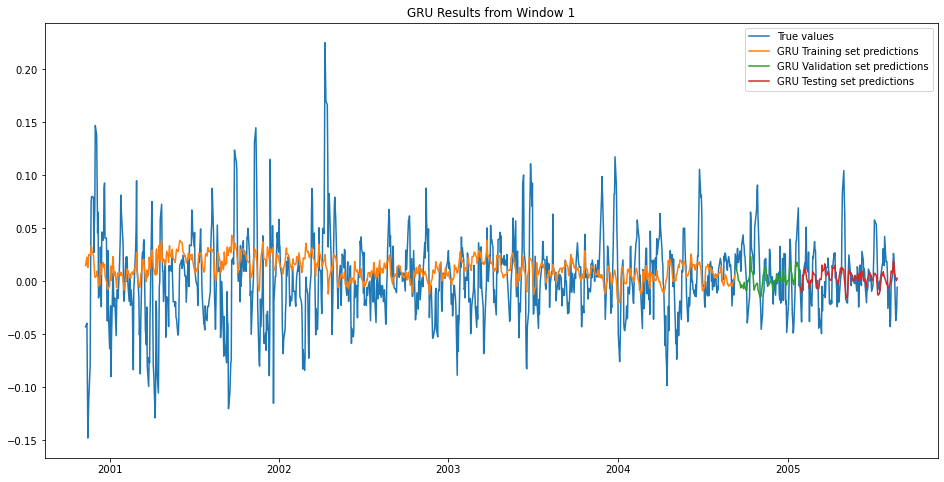

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0013295594287669587
RMSE = 0.036463124232119205
MAE = 0.02634202863867565
R-Squared = 0.03317389588794961

Results on Validation set: 
MSE = 0.0005635208997426715
RMSE = 0.02373859515099138
MAE = 0.015784312673987014
R-Squared = 0.08759644427387003

Results on Testing set: 
MSE = 0.001037744970242325
RMSE = 0.032214049268018526
MAE = 0.026550696942035004
R-Squared = -0.02087996237893197



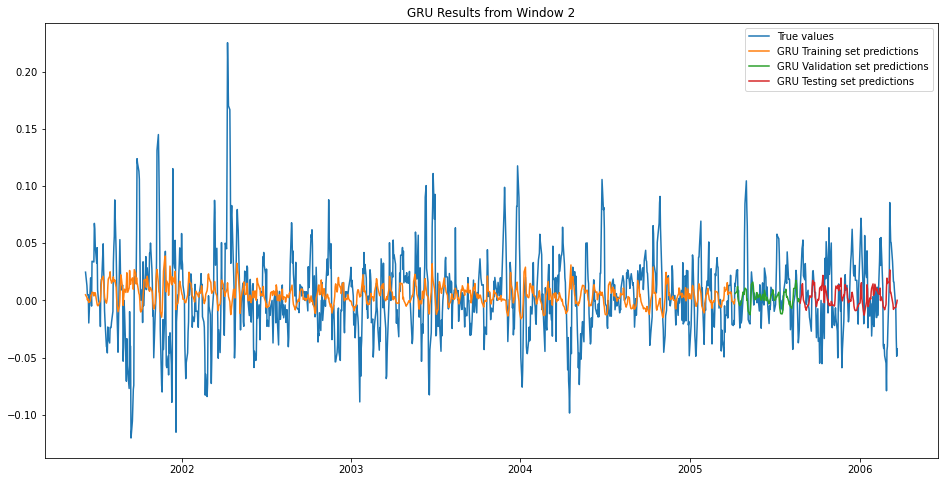

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0010708541291473259
RMSE = 0.03272390760815899
MAE = 0.02390163717907763
R-Squared = 0.04047227885377369

Results on Validation set: 
MSE = 0.0010525920263803363
RMSE = 0.03244367467443132
MAE = 0.02606675475912707
R-Squared = 0.03538281661967657

Results on Testing set: 
MSE = 0.0016545599694987208
RMSE = 0.04067628264110083
MAE = 0.03191400612681642
R-Squared = 0.02753476754162798



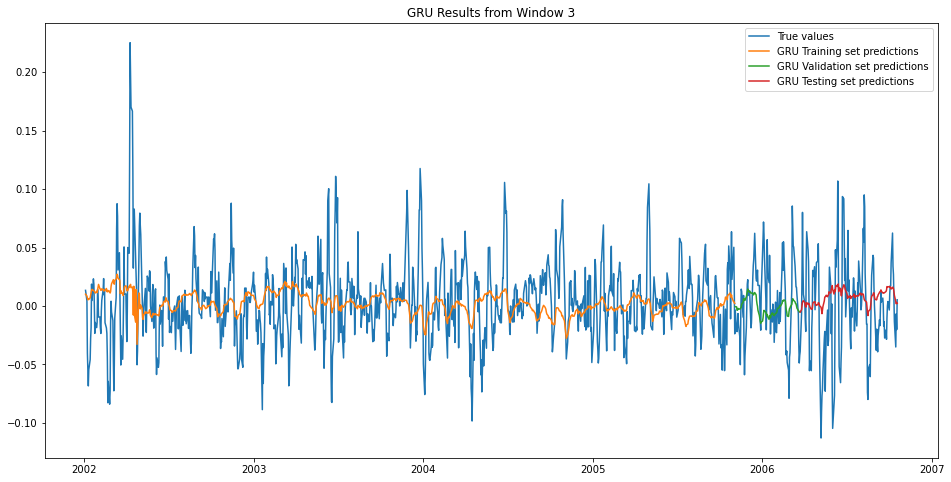

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0011068979380300463
RMSE = 0.03327007571422173
MAE = 0.02594682890291481
R-Squared = -0.12581771609096637

Results on Validation set: 
MSE = 0.0013567565221007153
RMSE = 0.036834176006810784
MAE = 0.02820537631576697
R-Squared = 0.15172633116154655

Results on Testing set: 
MSE = 0.0008809490888913485
RMSE = 0.029680786527505443
MAE = 0.023244350923879983
R-Squared = 0.023663487774118974



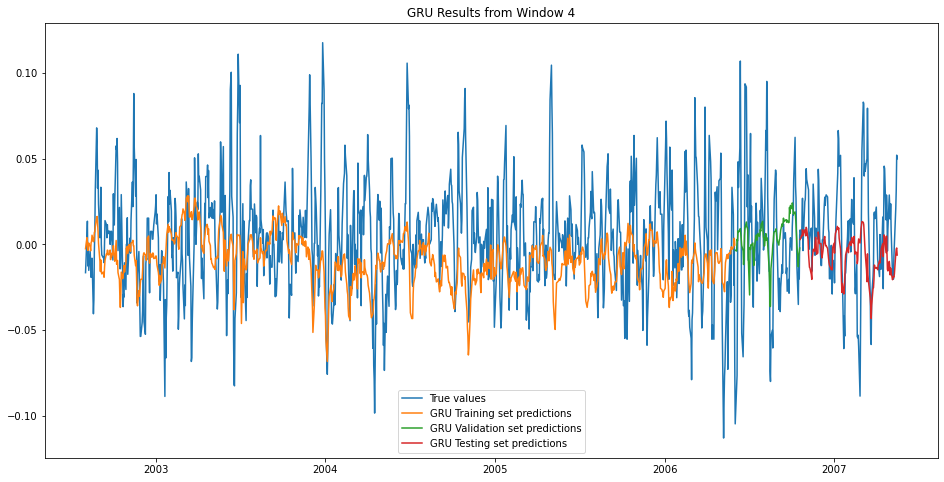

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0010141316663600792
RMSE = 0.031845433995473814
MAE = 0.024316890256115574
R-Squared = 0.029746610016927133

Results on Validation set: 
MSE = 0.0009446331304085378
RMSE = 0.03073488458427228
MAE = 0.023363676782721794
R-Squared = 0.20222283238198202

Results on Testing set: 
MSE = 0.000790845164211757
RMSE = 0.02812196942270859
MAE = 0.022896126669320012
R-Squared = 0.024847184518394516



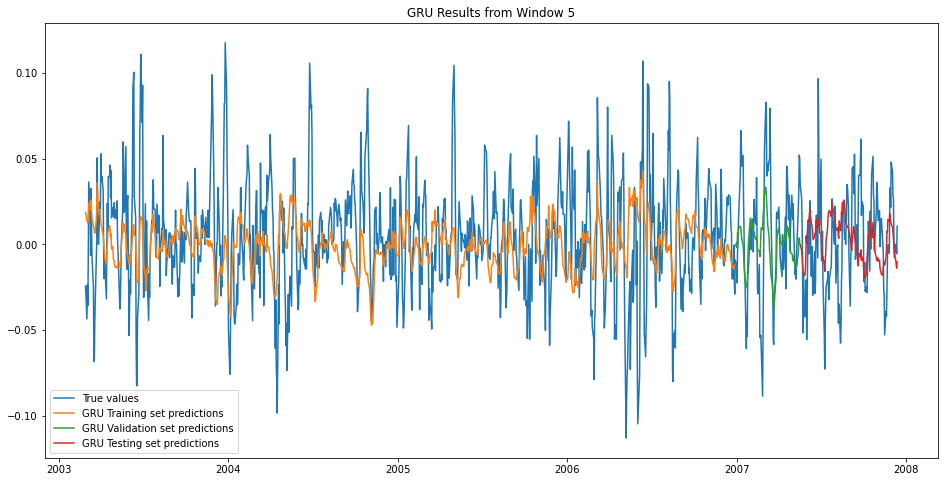

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0009956180065389113
RMSE = 0.03155341513273819
MAE = 0.023924233787866504
R-Squared = 0.050985846865062356

Results on Validation set: 
MSE = 0.0006745175792843064
RMSE = 0.02597147626309114
MAE = 0.02079755836020442
R-Squared = 0.005607558382844435

Results on Testing set: 
MSE = 0.0029308730528613417
RMSE = 0.05413753829702032
MAE = 0.04237631654737584
R-Squared = -0.8315331123776637



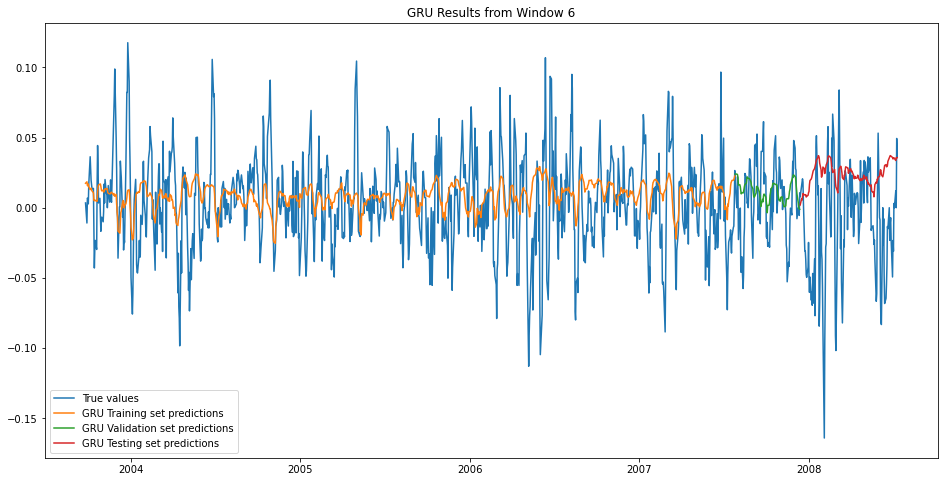

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0012388978568734592
RMSE = 0.03519798086358732
MAE = 0.027553421095768665
R-Squared = -0.15520577114538514

Results on Validation set: 
MSE = 0.0012811302206498334
RMSE = 0.035792879468545605
MAE = 0.026889218571577445
R-Squared = 0.010900305534325305

Results on Testing set: 
MSE = 0.002604637188602343
RMSE = 0.05103564625438129
MAE = 0.04051340569498988
R-Squared = -0.02276990342710472



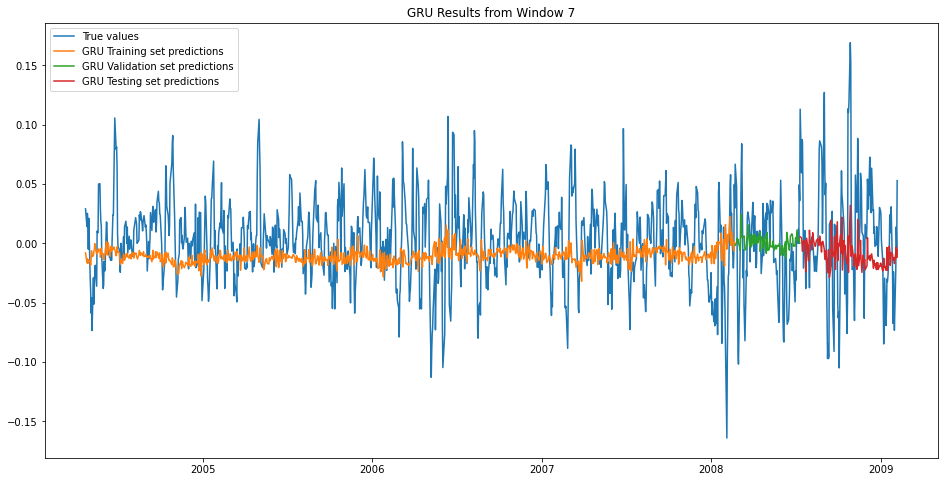

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.001203953075633749
RMSE = 0.03469802697033001
MAE = 0.026442646865147836
R-Squared = -0.0017612791995689214

Results on Validation set: 
MSE = 0.002201085134673879
RMSE = 0.04691572374667025
MAE = 0.03553780560249983
R-Squared = 0.12666896619915835

Results on Testing set: 
MSE = 0.0012733927691559188
RMSE = 0.03568462931229521
MAE = 0.028370389908153156
R-Squared = 0.05848351692184639



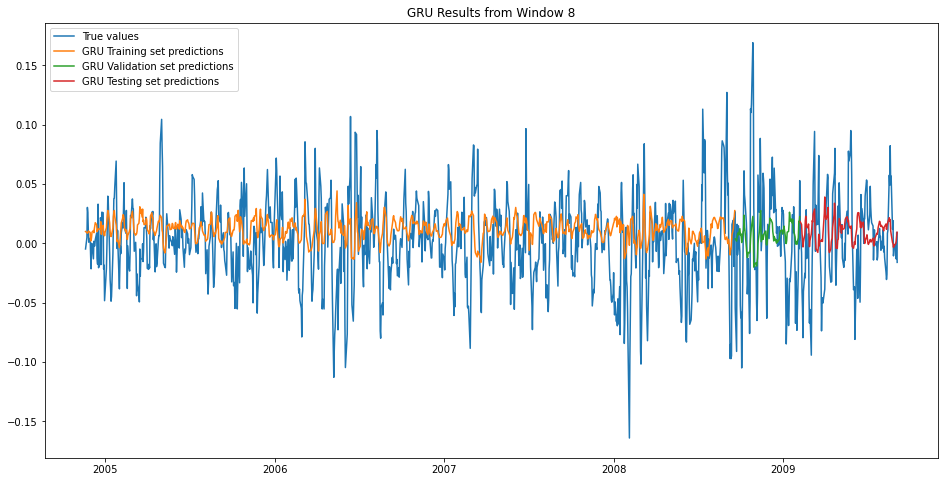

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0016068605547320132
RMSE = 0.040085665202563535
MAE = 0.030906284899114213
R-Squared = -0.11433201932072645

Results on Validation set: 
MSE = 0.0007508969834982963
RMSE = 0.0274024995848608
MAE = 0.020631745611984373
R-Squared = 0.29530651160787036

Results on Testing set: 
MSE = 0.0005757337417324577
RMSE = 0.023994452311575227
MAE = 0.018636505821623982
R-Squared = -0.10399977509908154



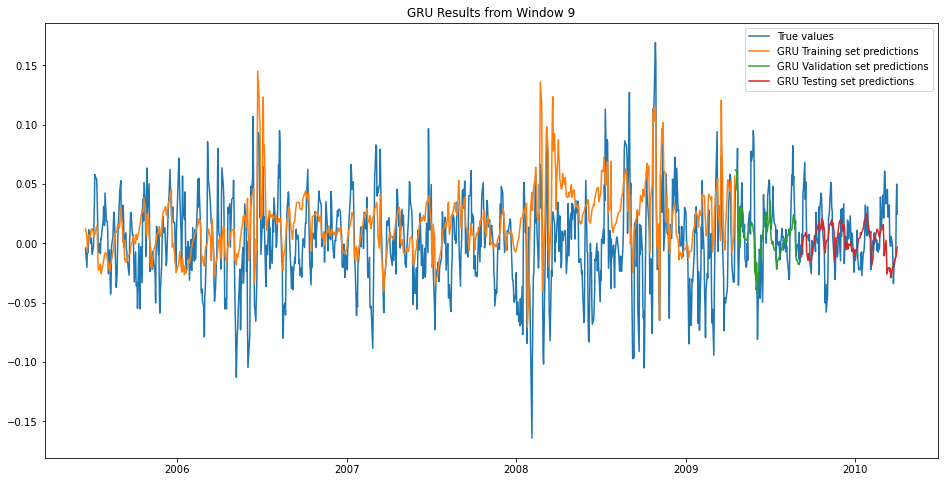

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.001451319162887783
RMSE = 0.0380961830488014
MAE = 0.028915770470441516
R-Squared = 0.020223486600668417

Results on Validation set: 
MSE = 0.00040957847048999984
RMSE = 0.0202380451252091
MAE = 0.015578324969692216
R-Squared = -0.02997111554560017

Results on Testing set: 
MSE = 0.0008235908955310248
RMSE = 0.028698273389370043
MAE = 0.023202132798034753
R-Squared = 0.017592914206029042



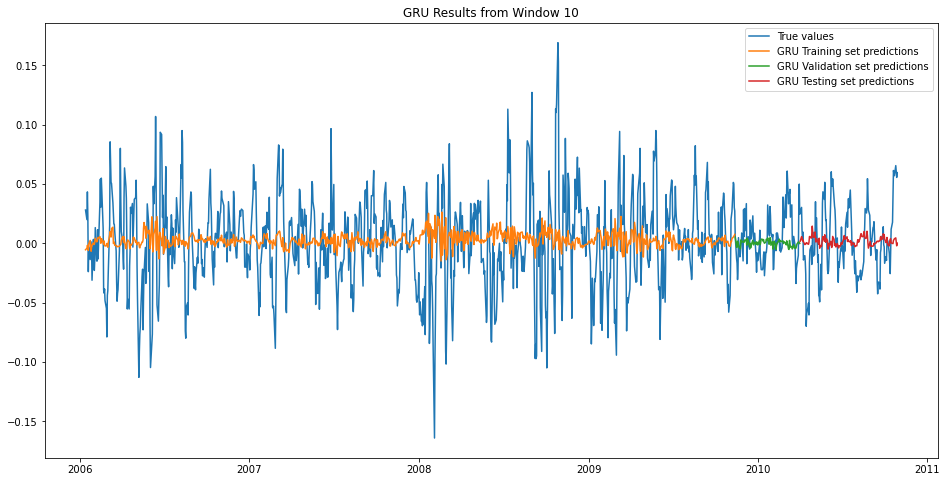

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.001252777395248828
RMSE = 0.035394595565549664
MAE = 0.026880260879589803
R-Squared = 0.037964629183178

Results on Validation set: 
MSE = 0.0006813287048927254
RMSE = 0.026102273941032903
MAE = 0.021091741334370494
R-Squared = 0.054775314701869804

Results on Testing set: 
MSE = 0.0008595644973708887
RMSE = 0.02931833039876058
MAE = 0.02304541190713127
R-Squared = -0.11314622465148072



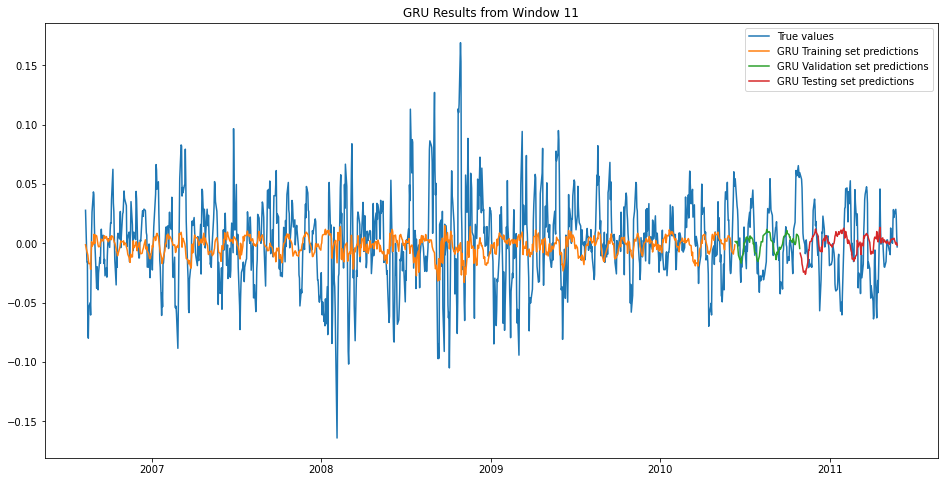

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0012878395189599785
RMSE = 0.035886481005526
MAE = 0.0273416951289053
R-Squared = -0.02620120417366323

Results on Validation set: 
MSE = 0.0009064562987322497
RMSE = 0.030107412687447085
MAE = 0.024367095962355916
R-Squared = 0.009646658845571143

Results on Testing set: 
MSE = 0.0009647062150588891
RMSE = 0.031059720138128886
MAE = 0.023778627748582616
R-Squared = -0.15593346508996575



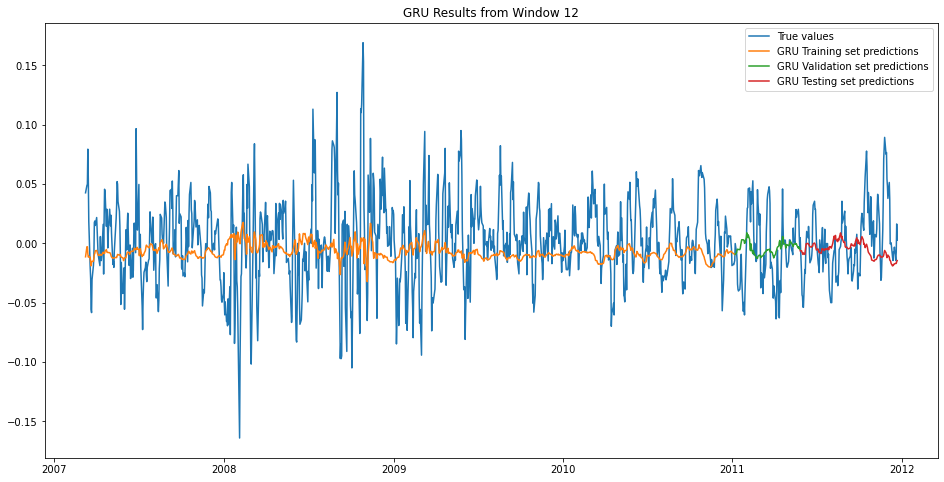

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0012494221378710044
RMSE = 0.035347165910027414
MAE = 0.026627241165790457
R-Squared = -0.0021278613095250254

Results on Validation set: 
MSE = 0.0008940908610476035
RMSE = 0.029901352160857268
MAE = 0.022914468091258907
R-Squared = -0.02414008506026022

Results on Testing set: 
MSE = 0.0004120238064033845
RMSE = 0.020298369550369913
MAE = 0.015932692409140057
R-Squared = 0.00787253702977786



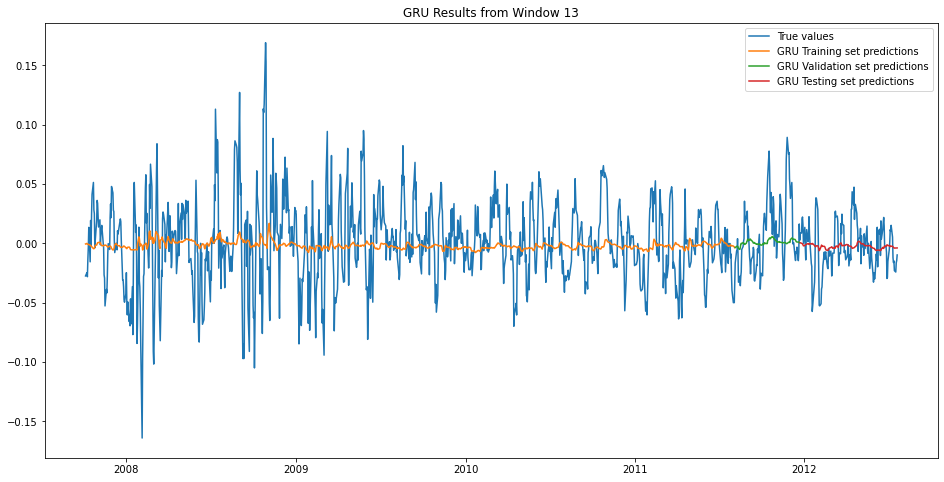

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0011314751313959328
RMSE = 0.033637406728164
MAE = 0.025998487594742856
R-Squared = 0.01076886461158677

Results on Validation set: 
MSE = 0.0002883325446884105
RMSE = 0.016980357613678533
MAE = 0.014281309000274361
R-Squared = 0.053387004301670093

Results on Testing set: 
MSE = 0.0007649931933551464
RMSE = 0.02765851032422293
MAE = 0.02149360756116024
R-Squared = 0.0376354903046352



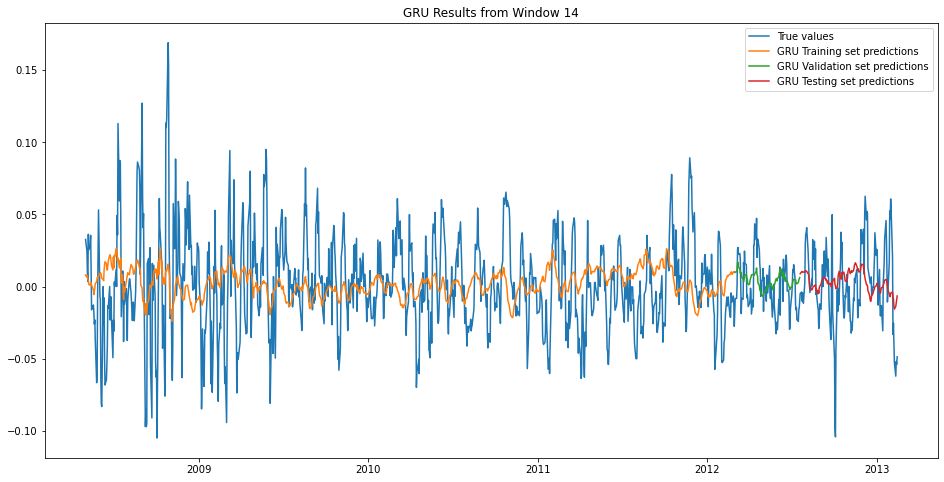

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0007297746217075194
RMSE = 0.027014341037817663
MAE = 0.020656518307614894
R-Squared = 0.09955137647450962

Results on Validation set: 
MSE = 0.0009320250316539802
RMSE = 0.030529085011738892
MAE = 0.02342801218656906
R-Squared = 0.05638885721556075

Results on Testing set: 
MSE = 0.0009506352658738371
RMSE = 0.030832373665902486
MAE = 0.024412301709788694
R-Squared = -0.06542281861486621



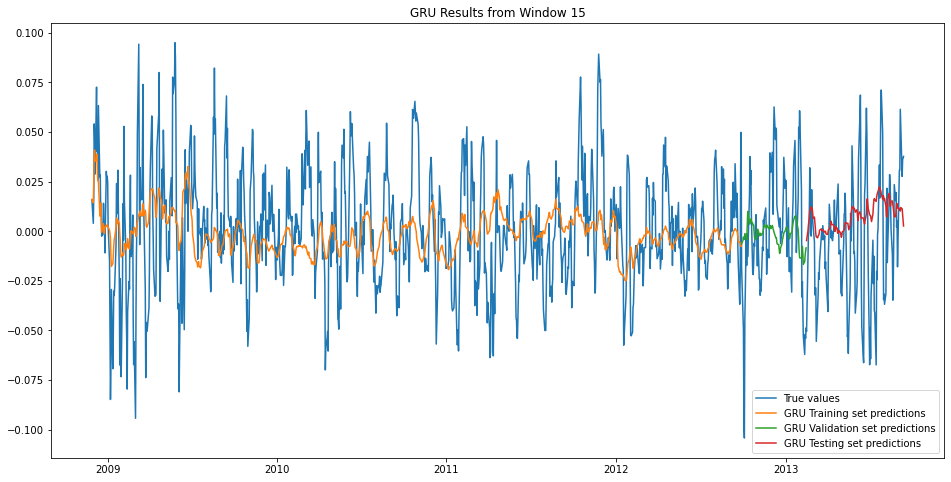

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0008679305648969103
RMSE = 0.029460661311262352
MAE = 0.02280356480454463
R-Squared = -0.2569125590038077

Results on Validation set: 
MSE = 0.0011541283405283591
RMSE = 0.033972464445906174
MAE = 0.02789208701334576
R-Squared = 0.001314967937700473

Results on Testing set: 
MSE = 0.002373724120521655
RMSE = 0.048720879718265095
MAE = 0.034513822225525355
R-Squared = -0.22476864121693563



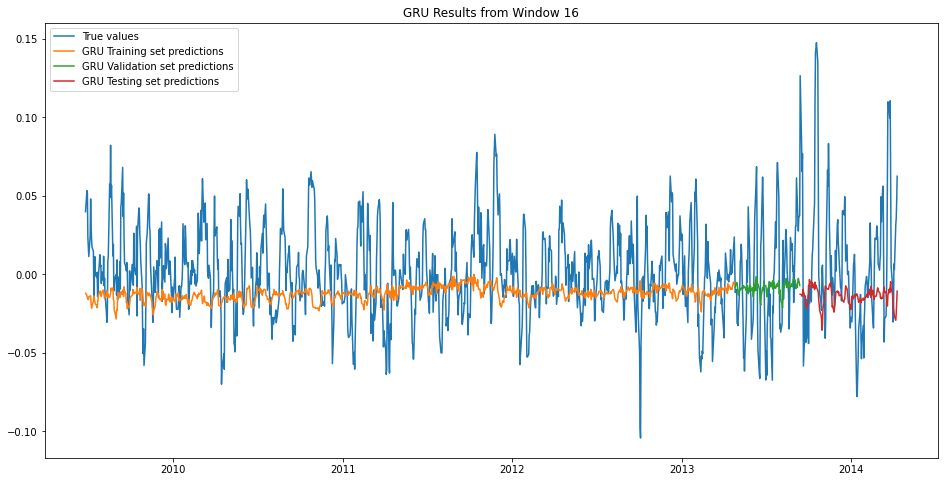

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.001069980997760359
RMSE = 0.03271056400859452
MAE = 0.025263543611301686
R-Squared = -0.20418775229017183

Results on Validation set: 
MSE = 0.0011941058090291523
RMSE = 0.034555836106642715
MAE = 0.026343383709619465
R-Squared = 0.09038315606495861

Results on Testing set: 
MSE = 0.001191370948327575
RMSE = 0.0345162418048022
MAE = 0.02598697942140232
R-Squared = -0.2389641338252495



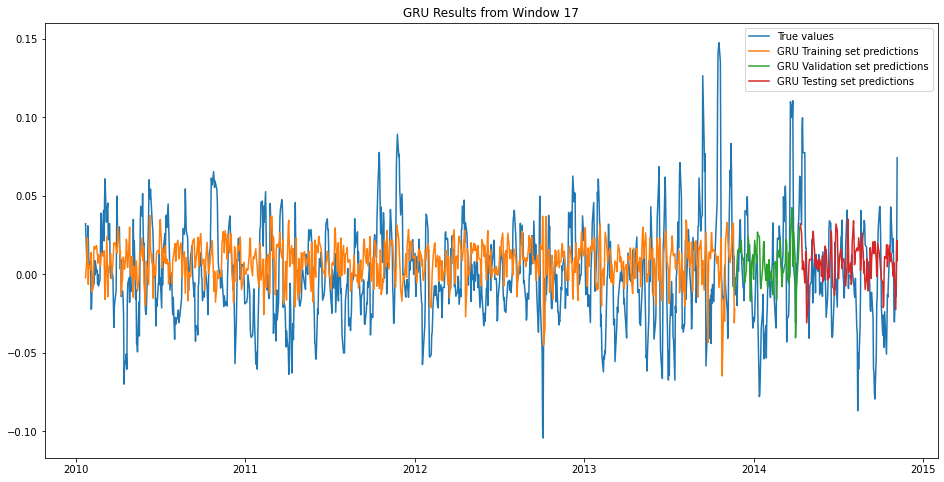

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0010332802145430534
RMSE = 0.0321446763017308
MAE = 0.023714835334032642
R-Squared = -0.07159580847429692

Results on Validation set: 
MSE = 0.0007904731940408218
RMSE = 0.02811535512919625
MAE = 0.021577259184243188
R-Squared = 0.09026526487502073

Results on Testing set: 
MSE = 0.0018112294013557851
RMSE = 0.042558540874374266
MAE = 0.0341913746734228
R-Squared = -0.2541723230126083



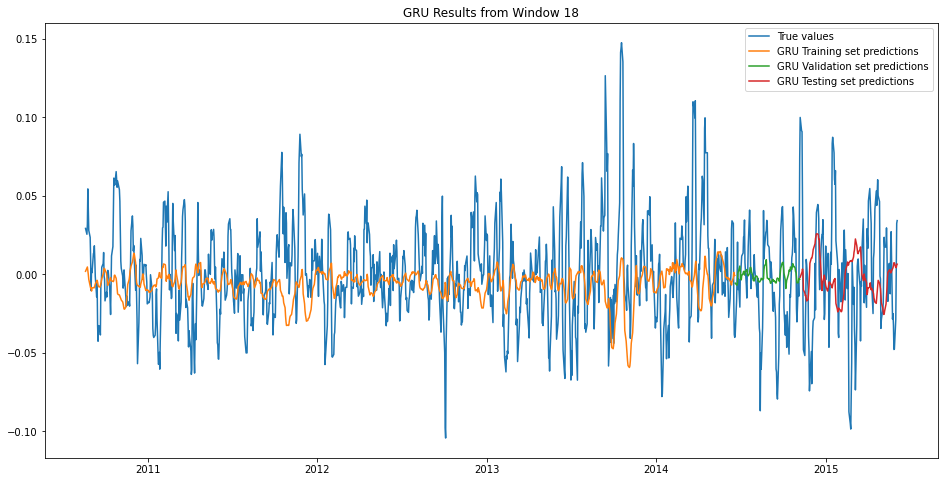

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0010641989828115697
RMSE = 0.03262206282275187
MAE = 0.024823612440106373
R-Squared = -0.04107196998438911

Results on Validation set: 
MSE = 0.0012581991807582252
RMSE = 0.035471103461243284
MAE = 0.027022538217622284
R-Squared = 0.03212136380936359

Results on Testing set: 
MSE = 0.001299128694176843
RMSE = 0.036043427891598256
MAE = 0.028758771119519674
R-Squared = -0.001482103872255669



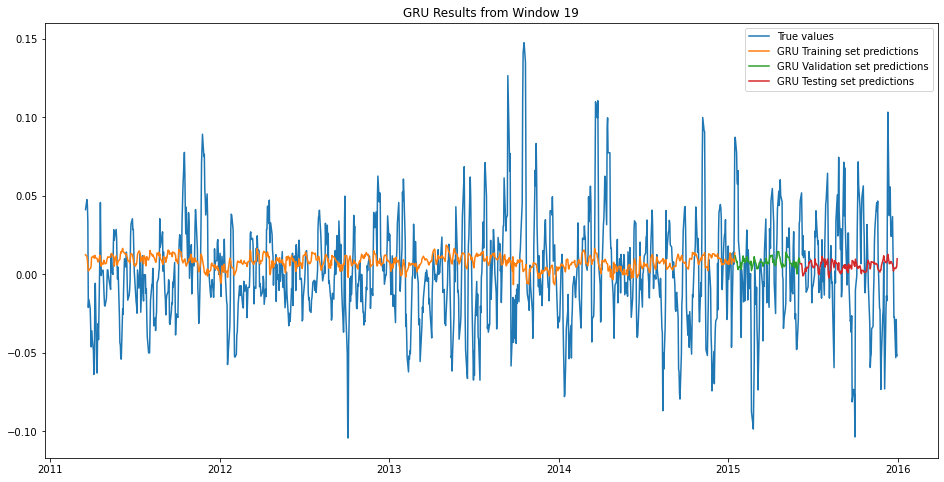

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.001076691515127402
RMSE = 0.03281297784608099
MAE = 0.02465330861054873
R-Squared = -0.001005212875564876

Results on Validation set: 
MSE = 0.0015214449405786922
RMSE = 0.039005703949277624
MAE = 0.032180031278655534
R-Squared = 0.11268998911731698

Results on Testing set: 
MSE = 0.00189421946547175
RMSE = 0.0435226316469001
MAE = 0.03427348692585753
R-Squared = -0.059473272591169746



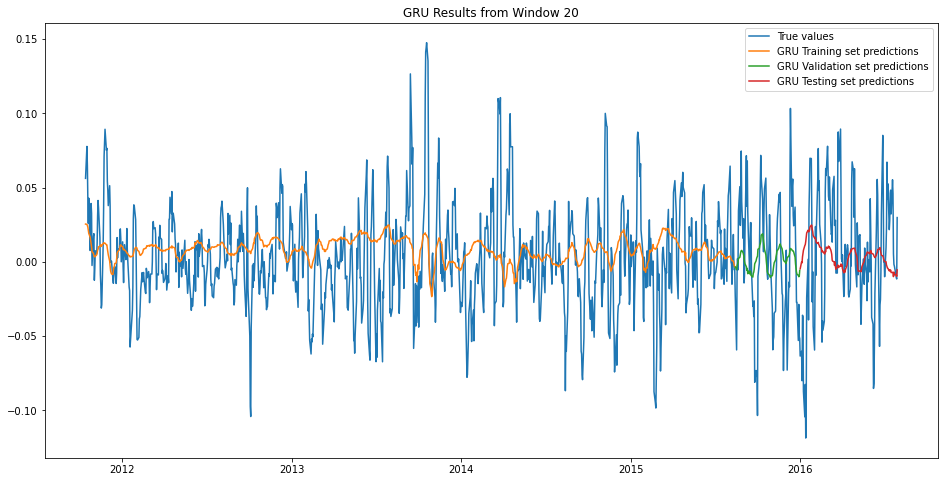

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0012780812116727608
RMSE = 0.03575026170075907
MAE = 0.026882753365967623
R-Squared = -0.006003109906112636

Results on Validation set: 
MSE = 0.0012759983639391037
RMSE = 0.03572111929852008
MAE = 0.02768073477918369
R-Squared = -0.05664500194395106

Results on Testing set: 
MSE = 0.0010005608040771674
RMSE = 0.03163164244988185
MAE = 0.02485965640517513
R-Squared = -0.17812649836771177



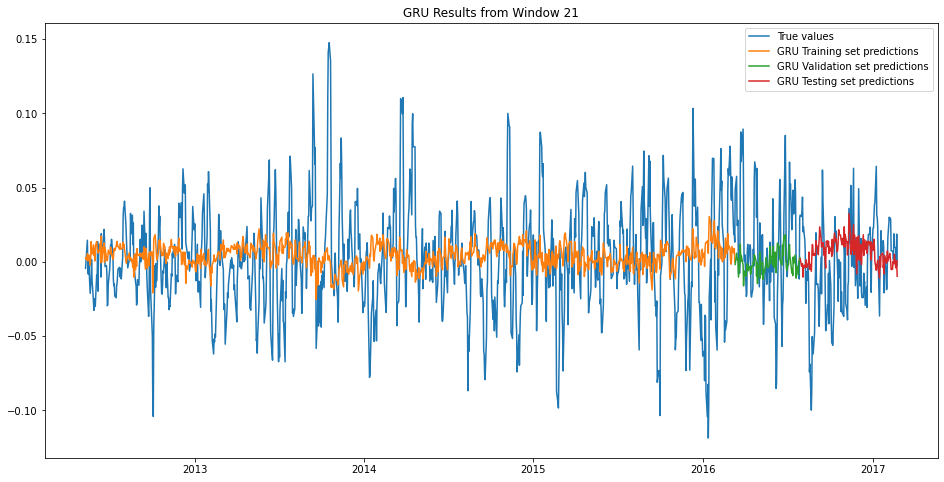

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0014134370401343089
RMSE = 0.03759570507563741
MAE = 0.02898109323413526
R-Squared = -0.011678474033365749

Results on Validation set: 
MSE = 0.0005386279275703285
RMSE = 0.023208359002099405
MAE = 0.018091437883596066
R-Squared = -7.014904289870394e-05

Results on Testing set: 
MSE = 0.001144962120838379
RMSE = 0.03383728891088024
MAE = 0.027170693585403912
R-Squared = -0.353984998780956



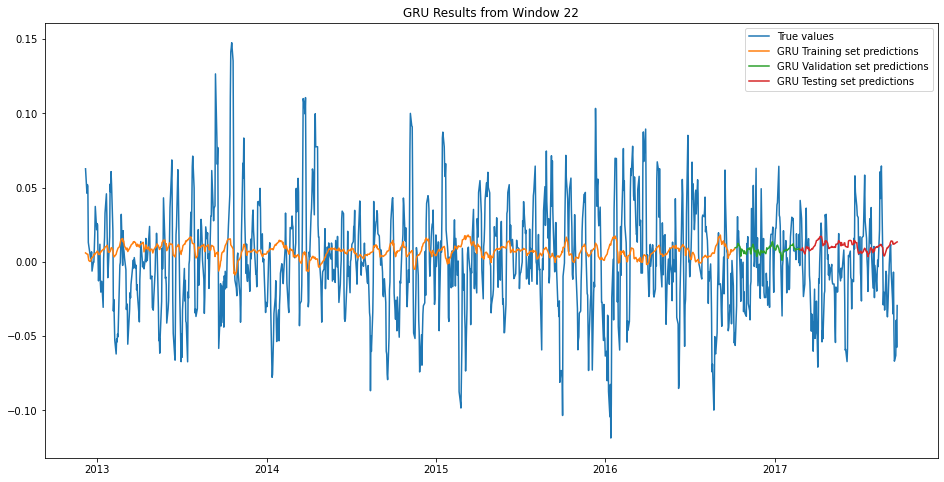

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0014938294932613423
RMSE = 0.03865009046899298
MAE = 0.029493992978378562
R-Squared = -0.10122942338684493

Results on Validation set: 
MSE = 0.0009000921966817121
RMSE = 0.030001536572010976
MAE = 0.022768610743058887
R-Squared = -0.04896512762655503

Results on Testing set: 
MSE = 0.0021661274583986588
RMSE = 0.04654167442624576
MAE = 0.034191815597952105
R-Squared = -0.18854368308965896



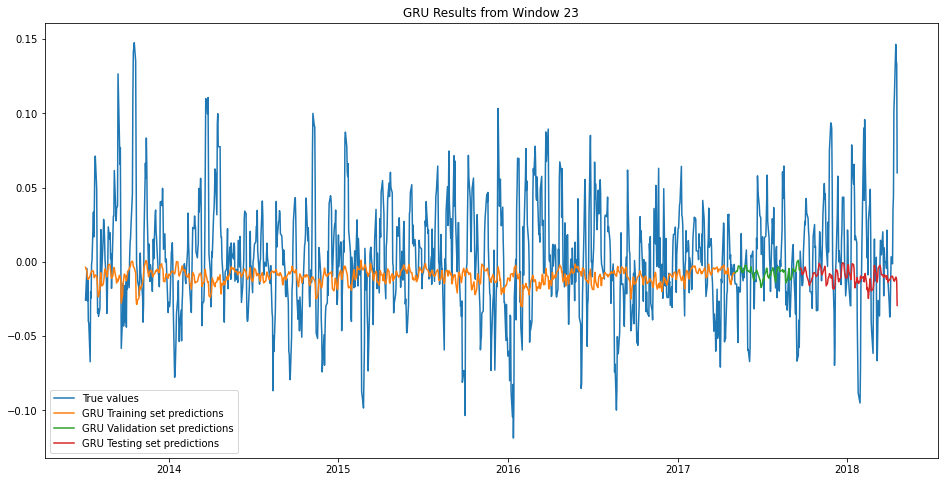

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0012859473190652711
RMSE = 0.03586010762763089
MAE = 0.027344175178032847
R-Squared = -0.041403649264681874

Results on Validation set: 
MSE = 0.002048032359400615
RMSE = 0.04525519151877069
MAE = 0.03320611994945368
R-Squared = 0.08567211146107723

Results on Testing set: 
MSE = 0.0009950709092481852
RMSE = 0.03154474455829664
MAE = 0.026908162130861266
R-Squared = -0.20170923587002698



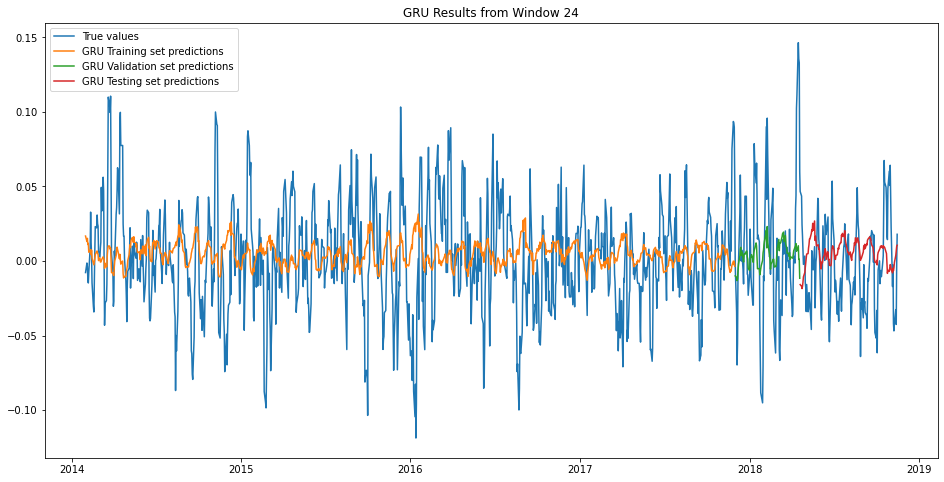

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4987

Results on Training set: 
MSE = 0.0014464699578925365
RMSE = 0.03803248556027513
MAE = 0.02948810557303299
R-Squared = -0.0854178400797132

Results on Validation set: 
MSE = 0.000837739479079802
RMSE = 0.02894372952955099
MAE = 0.02210659838338349
R-Squared = 0.03729675514565223

Results on Testing set: 
MSE = 0.001584432735833592
RMSE = 0.03980493356147692
MAE = 0.03153346080432414
R-Squared = -0.07302070127900673



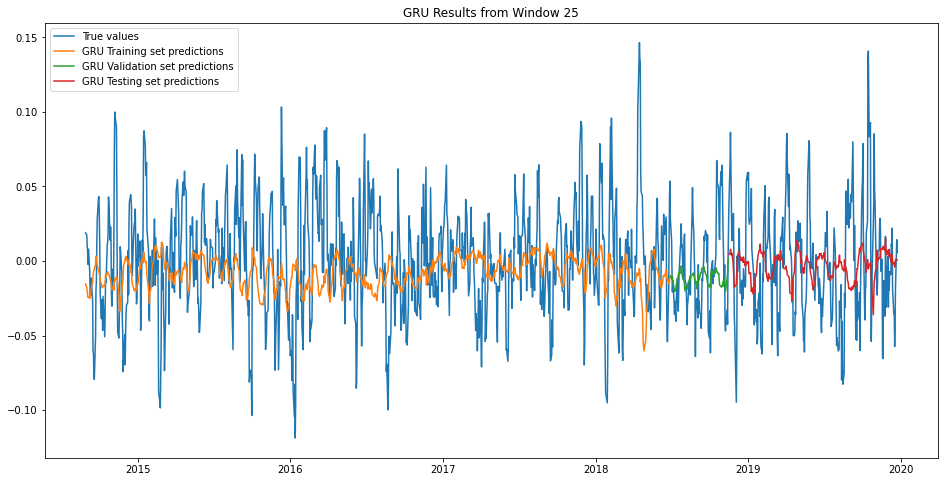

In [10]:
#Declaring model parameters
sequencelength = 131
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0012824313222610927
RMSE = 0.035811050281457715
MAE = 0.027470946770035053
R-Squared = -0.07465587257600892

GRU model results on the Testing set
MSE = 0.0013103086162777051
RMSE = 0.03619818526221591
MAE = 0.027539631236076344
R-Squared = -0.09867702274249557

Naive model results on the Testing set
MSE = 0.002567665639751379
RMSE = 0.0506721386932837
MAE = 0.038993075839202335
R-Squared = -1.1557430703137492

Drift model results on the Testing set
MSE = 0.003113650195758145
RMSE = 0.05580009135976522
MAE = 0.04270335981648968
R-Squared = -1.614137031306226



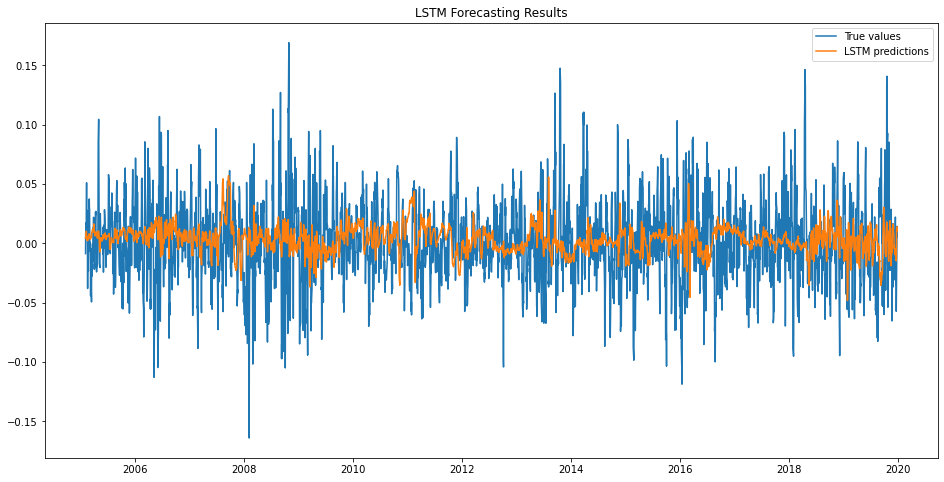

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

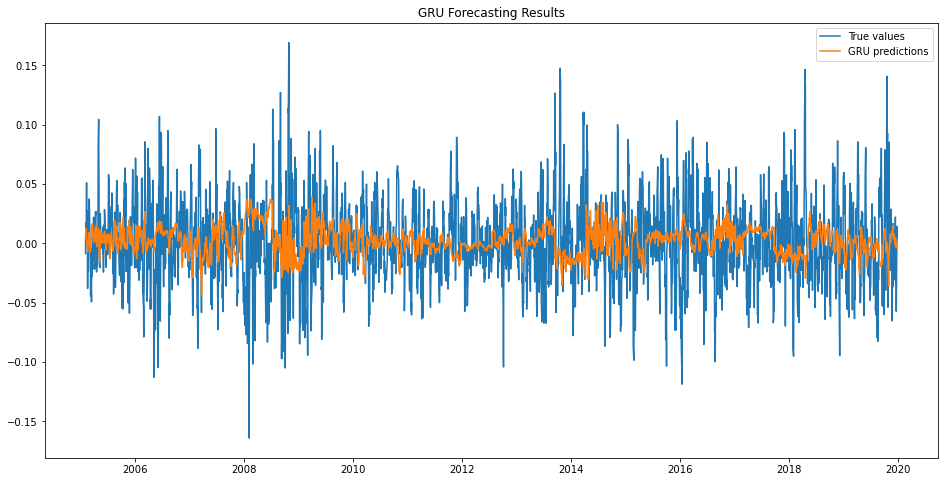

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

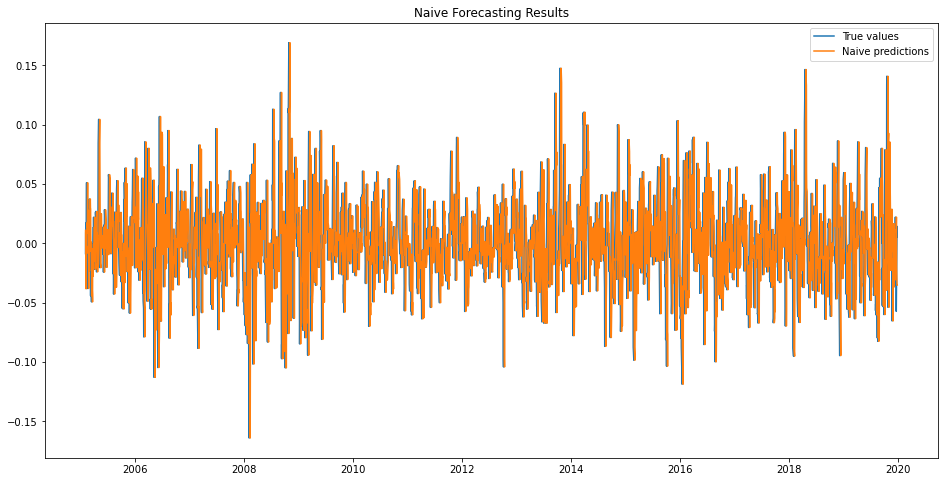

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

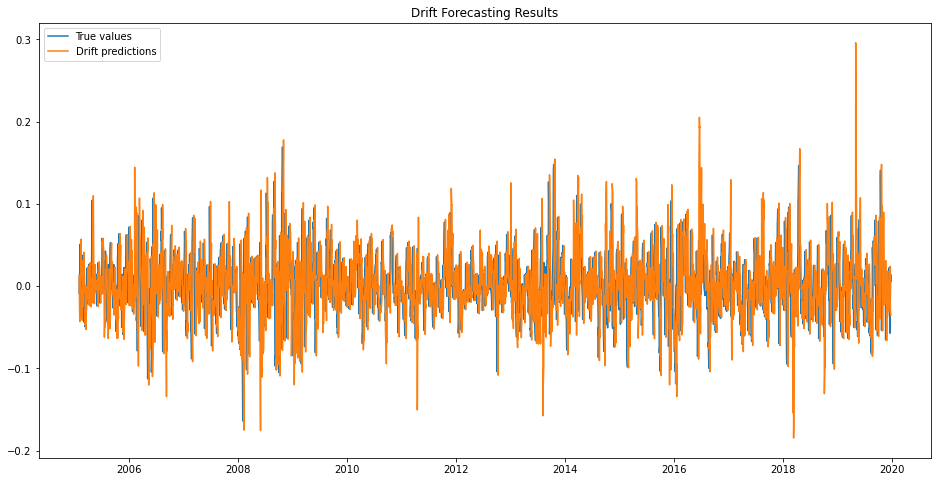

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['PIK LSTM'] = lstm_predictions[-numpreds:]
savePredictions['PIK GRU'] = gru_predictions[-numpreds:]
savePredictions['PIK Naive'] = naive_predictions[-numpreds:]
savePredictions['PIK Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./PIK_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

PIK LSTM   PIK GRU  PIK Naive  PIK Drift
Date                                                
2005-02-03  0.004312  0.004971   0.010882   0.012747
2005-02-04  0.005847  0.005137  -0.004338  -0.004639
2005-02-07  0.008153  0.009997  -0.038384  -0.043277
2005-02-08  0.010108  0.012359  -0.017784  -0.019838
2005-02-09  0.009282  0.008686  -0.002186  -0.002187